In [2]:
# Tải và giải nén dataset
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip food11-image-dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset
License(s): CC0-1.0




  0%|          | 0.00/1.08G [00:00<?, ?B/s]
  0%|          | 1.00M/1.08G [00:01<18:28, 1.05MB/s]
  0%|          | 2.00M/1.08G [00:01<11:24, 1.70MB/s]
  0%|          | 3.00M/1.08G [00:02<13:32, 1.43MB/s]
  0%|          | 4.00M/1.08G [00:02<12:57, 1.49MB/s]
  0%|          | 5.00M/1.08G [00:03<12:22, 1.56MB/s]
  1%|          | 6.00M/1.08G [00:03<09:42, 1.99MB/s]
  1%|          | 7.00M/1.08G [00:04<08:16, 2.33MB/s]
  1%|          | 8.00M/1.08G [00:04<08:19, 2.31MB/s]
  1%|          | 9.00M/1.08G [00:04<07:13, 2.66MB/s]
  1%|          | 10.0M/1.08G [00:05<06:27, 2.98MB/s]
  1%|          | 11.0M/1.08G [00:05<05:57, 3.22MB/s]
  1%|          | 12.0M/1.08G [00:05<05:48, 3.30MB/s]
  1%|          | 13.0M/1.08G [00:06<06:55, 2.77MB/s]
  1%|▏         | 14.0M/1.08G [00:06<06:25, 2.98MB/s]
  1%|▏         | 15.0M/1.08G [00:06<06:09, 3.11MB/s]
  1%|▏         | 16.0M/1.08G [00:06<05:41, 3.36MB/s]
  2%|▏         | 17.0M/1.08G [00:07<05:40, 3.36MB/s]
  2%|▏         | 18.0M/1.08G [00:07<05:23, 3.53MB/s]
 

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch import nn, optim
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.cuda.amp import GradScaler, autocast

In [8]:
# Định nghĩa lớp xử lý dataset Food11
# Lấy data và preprocess trước khi bỏ vào model
class Food11Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # Địa chỉ dẫn đễn các file hình ảnh
        self.transform = transform
        self.classes = os.listdir(root_dir) # Array chứa tên các thư mục
        self.file_paths = []
        self.labels = []
        # Tạo array các đường dẫn đến từng ảnh (file_paths)
        # Tạo array các vị trí thư mục mà file nằm ở đó (labels) (vd: thư mục Bread là 0, Dairy product là 1)
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                self.file_paths.append(os.path.join(class_dir, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Định nghĩa hàm huấn luyện mô hình (train_model)
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, early_stopping, num_epochs=5):
    for epoch in range(num_epochs):
        model.train() #  Huấn luyện mô hình
        running_loss = 0.0 # Chỉnh loss về 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

        # Xác thực mô hình bằng thư mục thẩm định
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = correct / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

        # Kiểm tra dừng sớm để tránh quá tải
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Scheduler thêm 1 bậc
        scheduler.step()

def evaluate_model(model, eval_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in eval_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(eval_loader.dataset)
    print(f"Evaluation Accuracy: {accuracy}")

def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image).logits
        pred = torch.argmax(outputs, dim=1).item()
    return train_dataset.classes[pred]

class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [5]:
# Tải mô hình ViT đã được pre-train
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=11, ignore_mismatched_sizes=True)

c:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Ngưng các tham số backbone
for param in model.vit.parameters():
    param.requires_grad = False

# Thiết lập chức năng tối ưu hóa và mất
# optimizer = optim.AdamW(model.parameters(), lr=5e-5)
optimizer = optim.AdamW(model.classifier.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

In [7]:
# Khởi tạo các thành phần cho việc huấn luyện
early_stopping = EarlyStopping(patience=3, delta=0.001)
scaler = GradScaler()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
# Tạo các tập dữ liệu
train_dataset = Food11Dataset(root_dir='./training', transform=transform)
val_dataset = Food11Dataset(root_dir='./validation', transform=transform)
eval_dataset = Food11Dataset(root_dir='./evaluation', transform=transform)

In [12]:
# Tải các tập dữ liệu
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [13]:
# Huấn luyện bằng GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
# Huấn luyện mô hình
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, early_stopping, num_epochs=10)

C:\Users\nhatt\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/10, Loss: 1.9707095082909545
Validation Loss: 1.574909687594131, Validation Accuracy: 0.5556851311953352
Epoch 2/10, Loss: 1.350111918734887
Validation Loss: 1.1849059771608423, Validation Accuracy: 0.6816326530612244
Epoch 3/10, Loss: 1.1615307091895044
Validation Loss: 1.1685198555114094, Validation Accuracy: 0.6865889212827988
Epoch 4/10, Loss: 1.1315318220641621
Validation Loss: 1.1453431200374056, Validation Accuracy: 0.6921282798833819
Epoch 5/10, Loss: 1.118928369002049
Validation Loss: 1.1378212183437966, Validation Accuracy: 0.6965014577259475
Epoch 6/10, Loss: 1.1152044654278308
Validation Loss: 1.1443215734152883, Validation Accuracy: 0.6900874635568514
Epoch 7/10, Loss: 1.12511428235804
Validation Loss: 1.1509210897816553, Validation Accuracy: 0.6825072886297376
Epoch 8/10, Loss: 1.1151988427230068
Validation Loss: 1.1287829281279333, Validation Accuracy: 0.6935860058309038
Epoch 9/10, Loss: 1.119549561086982
Validation Loss: 1.1391570913019005, Validation Accuracy:

In [15]:
# Đánh giá mô hình
evaluate_model(model, eval_loader)

Evaluation Accuracy: 0.7149686286226471


In [20]:
# Dự đoán hình ảnh thức ăn mới
image_path = './image.jpg'
predicted_class = predict_image(model, image_path)
print(f"Dự đoán thức ăn: {predicted_class}")

Dự đoán thức ăn: Egg


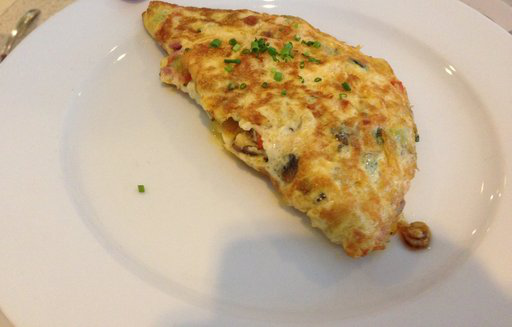

In [5]:
display(Image.open('./image.jpg'))